In [ ]:
!pip install -q transformers

     |████████████████████████████████| 4.9 MB 38.1 MB/s 
     |████████████████████████████████| 6.6 MB 54.3 MB/s 
     |████████████████████████████████| 163 kB 73.2 MB/s 


In [ ]:
!pip install -q tokenization

In [ ]:
!pip install -q sentencepiece

     |████████████████████████████████| 1.3 MB 29.5 MB/s 


In [ ]:
!wget --output-document='./token_1.py' https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/tools/tokenization.py

--2022-10-05 15:19:07--  https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/tools/tokenization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16591 (16K) [text/plain]
Saving to: ‘./token_1.py’

./token_1.py        100%[===================>]  16.20K  --.-KB/s    in 0s      

2022-10-05 15:19:07 (100 MB/s) - ‘./token_1.py’ saved [16591/16591]



In [ ]:
%cd /content/
import token_1 as  tokenization

# Imports

In [ ]:
import numpy as np
import pandas as pd
import os
from transformers import BertTokenizer, BertModel
import torch

import transformers as ppb
import tensorflow as tf
import tensorflow_hub as hub
import time
from tqdm import tqdm

import tokenization
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Dataset

In [ ]:
!git clone 'https://github.com/ayaanzhaque/SDCNL.git'

Cloning into 'SDCNL'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 155 (delta 59), reused 97 (delta 24), pack-reused 0
Receiving objects: 100% (155/155), 5.65 MiB | 34.63 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [ ]:
!ls './SDCNL/data'

combined-set.csv  testing-set.csv  training-set.csv


In [ ]:
train = pd.read_csv('/content/SDCNL/data/training-set.csv', index_col=0).sort_index()[['selftext', 'is_suicide']].dropna()
train.head()

,selftext,is_suicide
0,I've been feeling really depressed and lonely ...,0
1,I literally broke down crying and asked to go ...,0
2,Any kind soul want to give a depressed person ...,0
3,literally though. have i done anything wrong,0
4,why does it hurt so much? Why can’t I be happy...,0


In [ ]:
test = pd.read_csv('/content/SDCNL/data/testing-set.csv', index_col=0).sort_index()[['selftext', 'is_suicide']].dropna()
test.head()

,selftext,is_suicide
23,Any song which you like which makes you feel g...,0
29,I find it difficult right now to believe a per...,0
30,so i’ve had a few run ins with counselors in t...,0
32,"Let's have some fucking fun, do stupid shit, l...",0
44,I feel the only thing that makes me even remot...,0


In [ ]:
label = preprocessing.LabelEncoder()
y_train = label.fit_transform(train['is_suicide'])
y_train = to_categorical(y_train)
print(y_train[:3])
print(y_train[-2:])


label = preprocessing.LabelEncoder()
y_test = label.fit_transform(test['is_suicide'])
y_test = to_categorical(y_test)
print(y_test[:3])
print(y_test[-2:])

[[1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]]
[[0. 1.]
 [0. 1.]]


In [ ]:
print(len(train), len(test))

1516 379


# BERT Embeddings

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def getFeatures(batch_1):

    tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512)))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])


    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape


    input_ids = torch.tensor(padded)
    attention_mask = torch.tensor(attention_mask)
    print('before with')
    with torch.no_grad():
        print('in with')
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    print('after with\n')

    features = last_hidden_states[0][:,-1,:].numpy() # use this line if you want the 2D BERT features
    # features = last_hidden_states[0].numpy() # use this line if you want the 3D BERT features

    return features

In [ ]:
df = data[['selftext', 'is_suicide']].dropna()
df = df.rename(columns={'selftext': 0, 'is_suicide': 1})
t0 = time.time()
ber = []
k = 200
for i in range(0, len(df), k):
    bert_features = getFeatures(df[i:i+k])
    ber.append(bert_features)
print("time taken:", str(time.time()-t0))

bert_features = np.zeros((len(df), ber[0].shape[1]))

np.save('content/bert_features.npy', bert_features)

In [ ]:
from IPython.display import clear_output


print('Upload numpy:')
files.upload()

clear_output()

In [ ]:
bert_features = np.load('/content/bert_features (1).npy')

# BERT Embeddings - 2

In [ ]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in tqdm(texts):
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

# BERT Classification

In [ ]:
!pip install tensorflow-text

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
pd.DataFrame(bert_features)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.005627,0.197340,0.255266,-0.202157,-0.127188,-0.023924,0.095443,-0.155857,-0.009765,0.199888,...,0.135710,-0.029776,-0.087515,-0.076553,0.333864,-0.538846,-0.308195,-0.292609,0.220776,-0.540935
1,0.041702,0.033158,0.391555,0.083243,-0.106265,0.007643,0.104453,0.318385,0.099034,-0.282493,...,0.254370,-0.175711,0.252428,-0.223801,0.207414,-0.140773,-0.297795,0.228355,-0.272897,-0.330350
2,0.124002,-0.305653,0.690137,0.400152,0.047422,-0.221045,0.383370,0.536844,0.036519,-0.449553,...,0.302180,-0.112828,-0.300580,0.049018,-0.011509,-0.183170,-0.481234,0.440657,0.101002,-0.424336
3,-0.067380,-0.306545,-0.084634,-0.082586,0.044260,-0.390153,0.344334,0.257576,-0.184936,-0.321719,...,0.708768,-0.302354,0.195586,-0.633363,0.031786,-0.063108,-0.263744,0.019093,0.128779,-0.033784
4,-0.093186,-0.096373,0.538901,0.187397,-0.235153,0.051056,0.359623,0.207580,0.168766,-0.277475,...,0.216742,-0.032568,0.162220,-0.206016,0.092918,-0.099344,-0.311719,-0.088092,-0.173600,-0.261069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,0.066812,0.207072,0.342999,-0.084594,-0.192420,-0.182517,0.308774,0.253753,0.262220,-0.047239,...,0.689600,-0.146555,-0.162750,-0.180754,0.272482,-0.121546,-0.254629,0.241042,-0.079238,-0.196741
1512,0.338397,0.066267,0.316055,-0.145459,-0.310907,0.011319,0.218389,0.154832,-0.150733,-0.346169,...,0.406083,0.084853,0.243279,-0.075377,0.503267,-0.057837,-0.470347,0.091725,-0.069153,-0.426897
1513,0.168676,0.177153,0.279387,-0.055107,0.007915,0.008404,0.169118,-0.186396,0.078828,-0.274420,...,-0.139662,0.229705,0.144622,0.011850,0.184867,-0.164814,-0.549298,0.110181,0.140944,-0.200547
1514,0.325733,0.150278,0.726998,-0.022928,-0.276218,-0.241435,0.224024,-0.056770,0.193431,-0.226460,...,0.520330,-0.191626,0.108536,0.006055,0.023296,0.209091,-0.139315,0.196952,0.012726,0.363018


array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bert_features,df['is_suicide'].to_numpy(), stratify=df['is_suicide'].to_numpy(), test_size = 0.25)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1137, 768)
(379, 768)
(1137,)
(379,)


In [ ]:
text_embedded_input = tf.keras.layers.Input(shape=(), dtype=tf.int32)
# preprocessed_text = bert_preprocess(text_input)
# outputs = bert_encoder(preprocessed_text)
# # Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(text_embedded_input)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)
# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_embedded_input], outputs = [l])


ValueError: ignored

# BERT Classification - 2

In [ ]:
def build_model(bert_layer, max_len):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

    clf_output = sequence_output[:, 0, :]

    lay = tf.keras.layers.Dense(512, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(128, activation='relu')(lay)
    lay = tf.keras.layers.Dense(64, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(len(y_train[0]), activation='softmax')(lay)

    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy', 'mae'])

    return model

In [ ]:
max_len = 512
train_input = bert_encode(train.selftext.values, tokenizer, max_len=max_len)
test_input = bert_encode(test.selftext.values, tokenizer, max_len=max_len)
train_labels = y_train
test_labels = y_test

100%|██████████| 379/379 [00:00<00:00, 429.27it/s]


In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_mask[0][0]',         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

train_sh = model.fit(
    train_input, train_labels,
    validation_split=0.25,
    epochs=50,
    callbacks=[checkpoint, earlystopping],
    batch_size=8,
    verbose=1
)

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.6464 - mae: 0.4227
Epoch 1: val_accuracy improved from -inf to 0.05805, saving model to model.h5
143/143 [==============================] - 164s 1s/step - loss: 0.6482 - accuracy: 0.6464 - mae: 0.4227 - val_loss: 1.2725 - val_accuracy: 0.0580 - val_mae: 0.8250
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.6974 - mae: 0.3561
Epoch 2: val_accuracy improved from 0.05805 to 0.47757, saving model to model.h5
143/143 [==============================] - 165s 1s/step - loss: 0.5890 - accuracy: 0.6974 - mae: 0.3561 - val_loss: 0.8911 - val_accuracy: 0.4776 - val_mae: 0.5780
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.7748 - mae: 0.2749
Epoch 3: val_accuracy improved from 0.47757 to 0.81530, saving model to model.h5
143/143 [==============================] - 165s 1s/step - loss: 0.4889 - accuracy: 0.7748 - mae: 0.274

# Testing

In [ ]:
model_best = tf.keras.models.load_model('/content/model.h5', custom_objects={'KerasLayer': bert_layer})

In [ ]:
y_pred = model_best.predict(test_input)
# y_pred = model.predict(test_input)

In [ ]:
y_test_ = [np.argmax(i) for i in y_test]
y_pred_ = [np.argmax(i) for i in y_pred]

              precision    recall  f1-score   support

           0       0.78      0.58      0.66       186
           1       0.68      0.84      0.75       193

    accuracy                           0.71       379
   macro avg       0.73      0.71      0.71       379
weighted avg       0.73      0.71      0.71       379



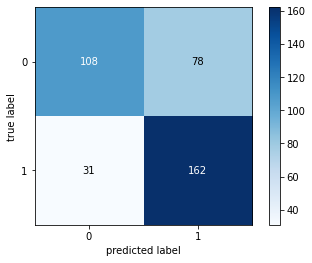

In [ ]:
in1 = y_pred_
true_classes = y_test_
class_labels = [str(i) for i in range(2)]
predicted_classes = (in1)
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
cm1 = confusion_matrix(true_classes,predicted_classes)
#print(cm2)
#Visualizing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm1, colorbar=True)
plt.show()